In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
players = pd.read_csv("player_stats3.csv")
players.dropna(inplace = True)

(3616, 109)

In [5]:
positions = ['RB', 'WR', 'QB', 'TE']
types = ['train', 'cv', 'test']
train = players[players.nfl_year.isin([2011, 2012, 2013, 2014, 2015, 2016])]
test = players[players.nfl_year == 2017]
features = players.select_dtypes(include=[np.number]).columns.tolist()
features.remove('player_fant_pt_test')

In [61]:
def show_results(model, estimator, position, y_pred, df_rmse, x_train, x_test, y_train, y_test):
    fix,ax = plt.subplots()
    plt.title('%s Predicted vs Actual Fantasy Scores'%position)
    ax.plot(list(y_test), label = "Actual values")
    ax.plot(list(y_pred), label = "Predicted values")
    plt.xlabel('%s ID'%position)
    plt.ylabel('Fantasy Score')
    plt.legend(loc='center left', bbox_to_anchor=[1,0.7])
    plt.show()

    train_rmse = np.sqrt(np.mean( (y_train - model.predict(x_train))**2.0 ) )
    test_rmse = np.sqrt(np.mean( (y_test - model.predict(x_test))**2.0 ))
    cv_rmse = np.sqrt(np.abs( cross_val_score(model, train[features], train['player_fant_pt_test'],\
        cv = 5, scoring = 'neg_mean_squared_error').mean() ))

    for val in types:
        df_rmse.loc[estimator + "_" + val, position] = eval(val + '_rmse')

### Random Forest Regressor

Position RB


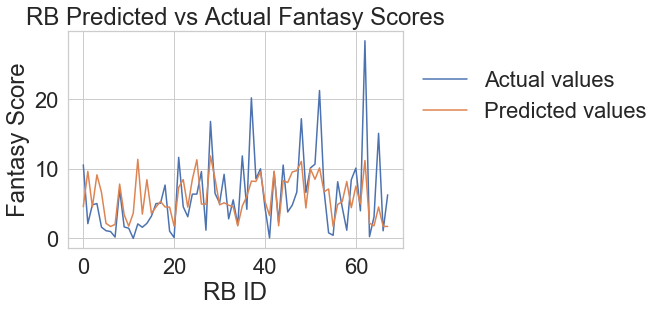

Position WR


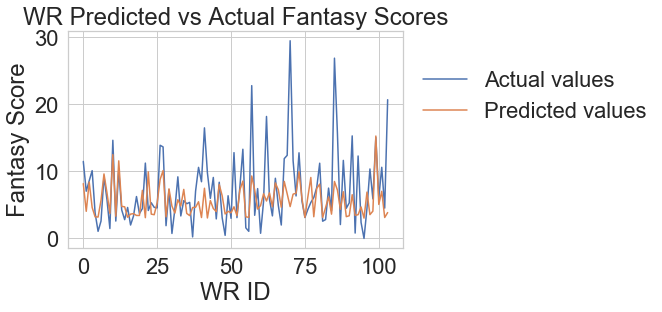

Position QB


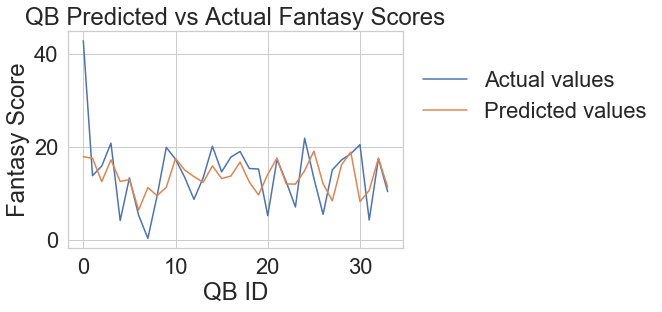

Position TE


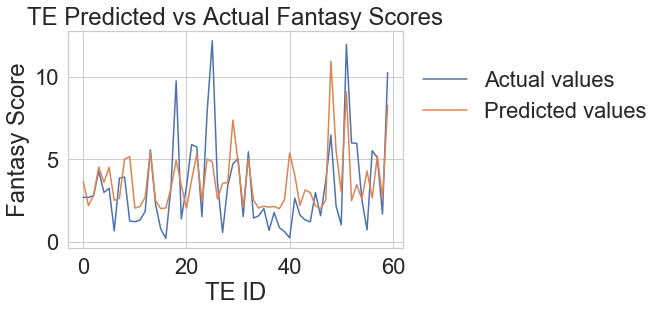

In [64]:
rmse_names = ["RandomForest" + '_' + y for y in types]
df_rmse = pd.DataFrame([[0.0] * len(positions) for j in range(len(rmse_names))], 
    index = rmse_names, columns = positions)
best_n = [50,100,100,70]

for i in range(len(positions)):
    position = positions[i]
    print ('Position %s' % position)
    pos_train = train.loc[train['player_pos'] == position,]
    pos_test = test.loc[test['player_pos'] == position,]
    x_train = pos_train[features]
    x_test = pos_test[features]
    y_train = pos_train['player_fant_pt_test']
    y_test = pos_test['player_fant_pt_test']
    n_estimators = [best_n[i]]

    param_grid = {'n_estimators': n_estimators}
    grid_search = GridSearchCV(RandomForestRegressor(max_depth=3), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    
    y_pred = grid_search.predict(x_test)
    show_results(grid_search, "RandomForest", position, y_pred, df_rmse, x_train, x_test, y_train, y_test)

In [8]:
df_rmse

,RB,WR,QB,TE
RandomForest_train,3.521269,2.937742,3.894353,2.139358
RandomForest_cv,3.802592,3.799784,3.799350,3.795091
RandomForest_test,4.590722,5.131457,6.530211,2.184964


### Random Forest Regressor PCA

In [17]:
ss = StandardScaler()
x_train_scaled = ss.fit_transform(train[features])
x_test_scaled = ss.transform(test[features])
y_train = np.array(train['player_fant_pt_test'])
y_test = np.array(test['player_fant_pt_test'])

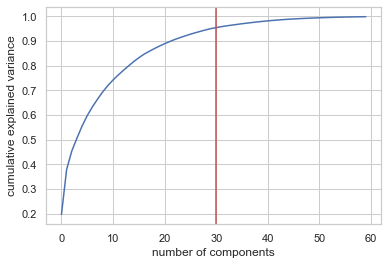

In [18]:
pca_test = PCA(n_components=60)
pca_test.fit(x_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(color='r', x=30, ymin=0, ymax=1)
plt.show()

In [21]:
def position_test_train_split(position):
    pos_train = train.loc[train['player_pos'] == position,]
    pos_test = test.loc[test['player_pos'] == position,]
    x_train = pos_train[features]
    x_test = pos_test[features]
    y_train = pos_train['player_fant_pt_test']
    y_test = pos_test['player_fant_pt_test']
    
    ss = StandardScaler()
    x_train_scaled = ss.fit_transform(x_train)
    x_test_scaled = ss.transform(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    pca = PCA(n_components=30)
    pca.fit(x_train_scaled)
    x_train_scaled_pca = pca.transform(x_train_scaled)
    x_test_scaled_pca = pca.transform(x_test_scaled)
    
    return x_train_scaled_pca, x_test_scaled_pca, y_train, y_test

In [22]:
def rf_rscv(x_train, y_train):
    rfr = RandomForestRegressor()
    rfr.fit(x_train, y_train)
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    max_features = ['log2', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
    min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
    min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
    bootstrap = [True, False]
    param_dist = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    rs = RandomizedSearchCV(rfr, 
                            param_dist, 
                            n_iter = 100, 
                            cv = 3, 
                            verbose = 1, 
                            n_jobs=-1, 
                            random_state=0)
    rs.fit(x_train, y_train)
    print(rs.best_params_)
    return rs

In [26]:
def plot_rscv(rs):
    rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    rs_df = rs_df.drop([
                'mean_fit_time', 
                'std_fit_time', 
                'mean_score_time',
                'std_score_time', 
                'params', 
                'split0_test_score', 
                'split1_test_score', 
                'split2_test_score', 
                'std_test_score'],
                axis=1)
    fig, axs = plt.subplots(ncols=3, nrows=2)
    sns.set(style="whitegrid", color_codes=True, font_scale = 2)
    fig.set_size_inches(30,25)
    sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightblue')
    axs[0,0].set_title(label = 'n_estimators')
    sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='yellow')
    axs[0,1].set_title(label = 'min_samples_split')
    sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
    axs[0,2].set_title(label = 'min_samples_leaf')
    sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='orange')
    axs[1,0].set_title(label = 'max_features')
    sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
    axs[1,1].set_title(label = 'max_depth')
    sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='purple')
    axs[1,2].set_title(label = 'bootstrap')
    plt.show()

#### QB

In [35]:
rmse_names = ["RandomForest" + '_' + y for y in types]
df_rmse = pd.DataFrame([[0.0] * len(positions) for j in range(len(rmse_names))], 
    index = rmse_names, columns = positions)

position = "QB"
x_train, x_test, y_train, y_test = position_test_train_split(position)
rs_qb = rf_rscv(x_train, y_train)

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.7s finished
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 600, 'min_samples_split': 23, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}


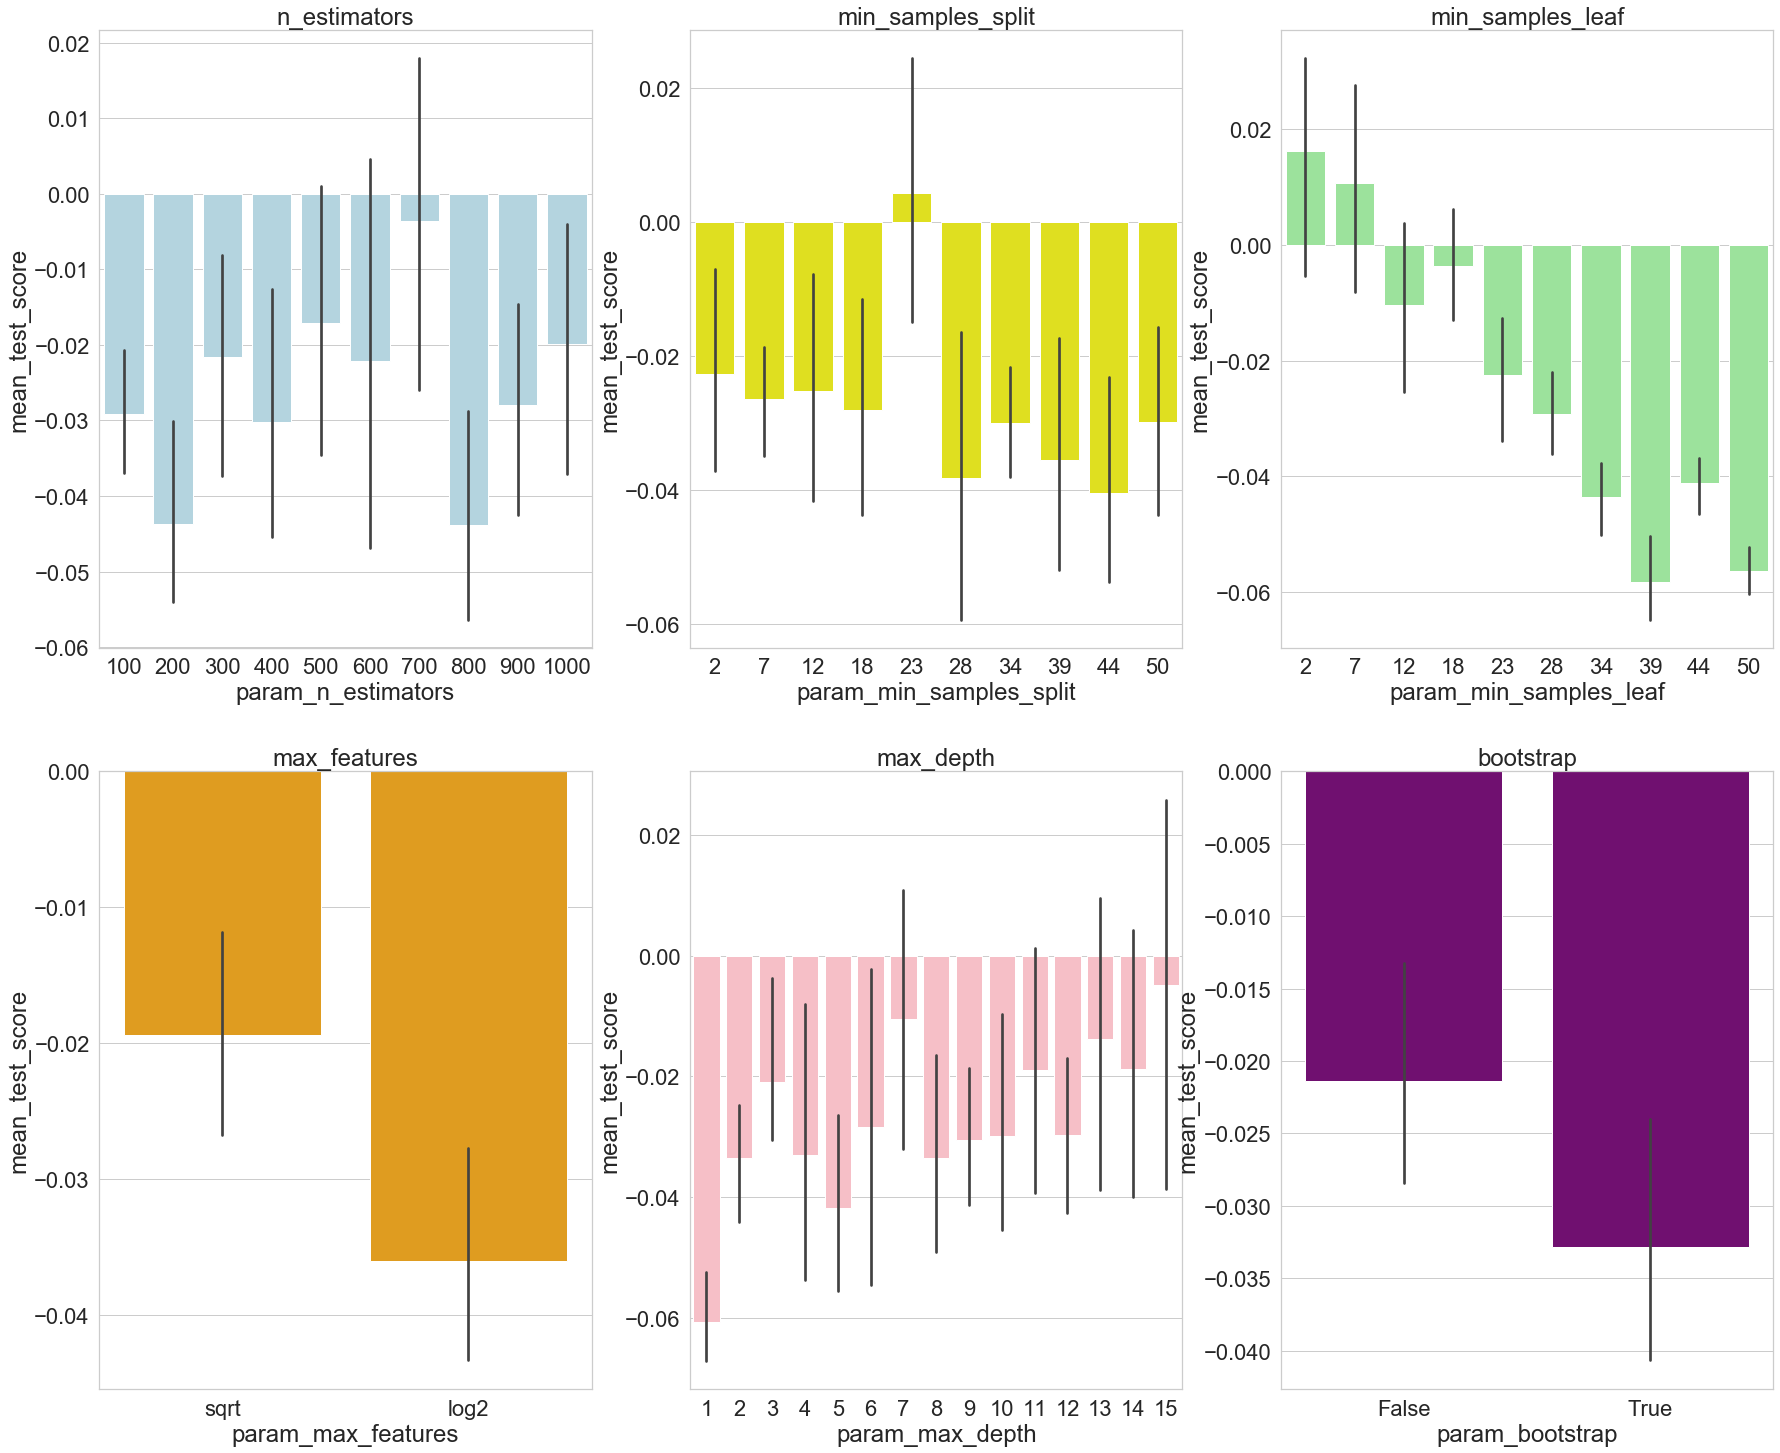

In [36]:
plot_rscv(rs_qb)

In [40]:
n_estimators = [500, 700, 1000]
max_features = ['sqrt']
max_depth = [15]
min_samples_split = [21, 22, 23, 24, 25]
min_samples_leaf = [2, 3, 4, 5, 6, 7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs_qb = GridSearchCV(RandomForestRegressor(), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs_qb.fit(x_train, y_train)
rfr_qb = gs_qb.best_estimator_
gs_qb.best_params_
# {'bootstrap': False,
# 'max_depth': 15,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 3,
# 'min_samples_split': 23,
# 'n_estimators': 500}

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.6min finished
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 23,
 'n_estimators': 500}

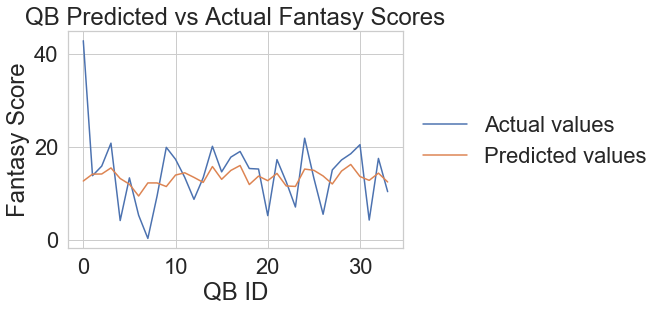

In [44]:
y_pred_qb = gs_qb.best_estimator_.predict(x_test)
show_results(gs_qb.best_estimator_, "RandomForest", "QB", y_pred_qb, df_rmse, x_train, x_test, y_train, y_test)

In [45]:
df_rmse

,RB,WR,QB,TE
RandomForest_train,0.0,0.0,3.194120,0.0
RandomForest_cv,0.0,0.0,3.818151,0.0
RandomForest_test,0.0,0.0,7.100701,0.0


### RB

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished


{'n_estimators': 700, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': False}


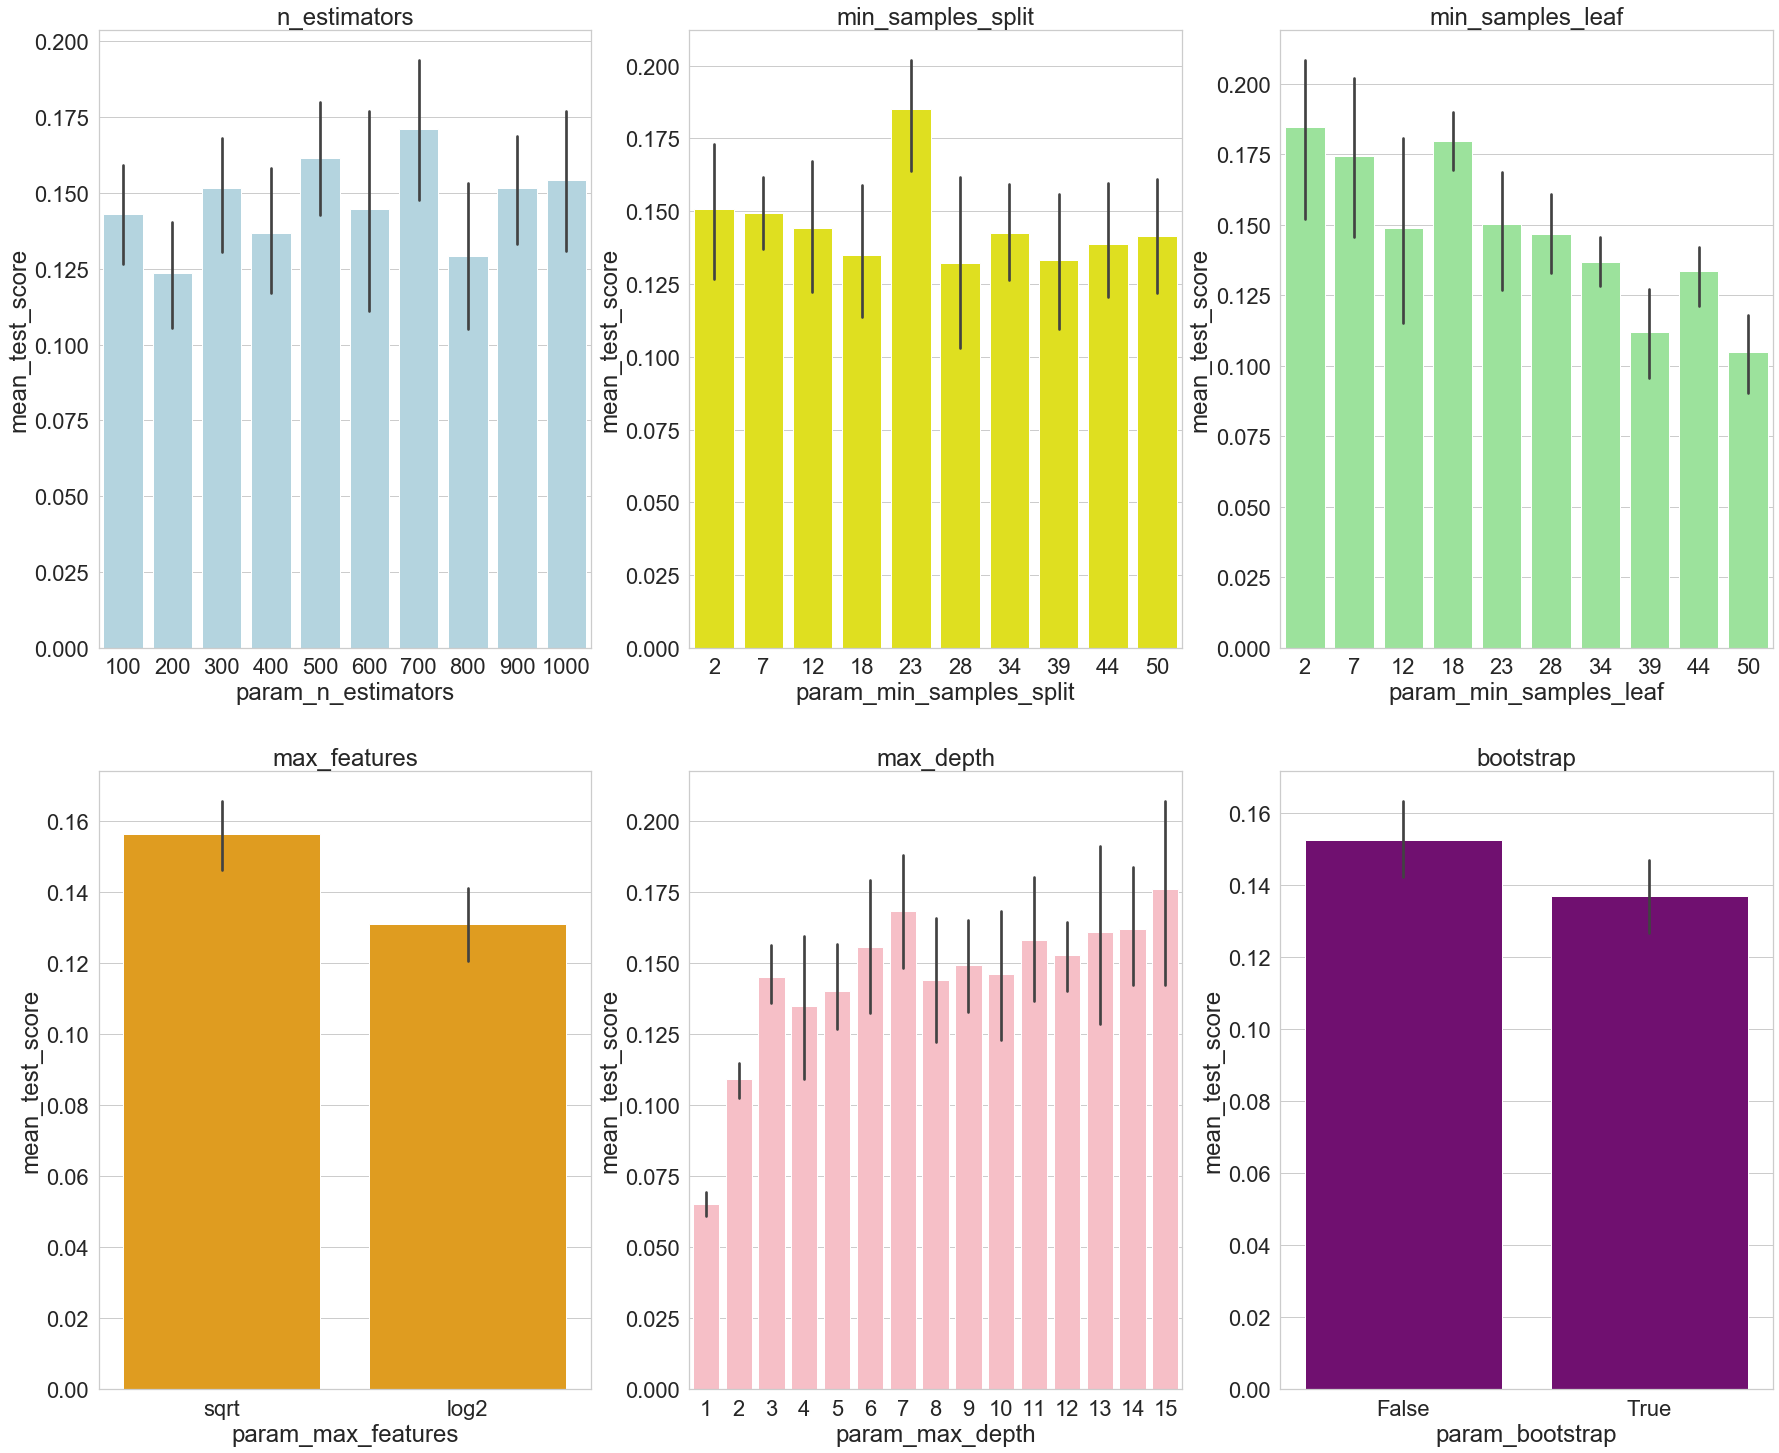

In [47]:
position = "RB"
x_train, x_test, y_train, y_test = position_test_train_split(position)
rs_rb = rf_rscv(x_train, y_train)
plot_rscv(rs_rb)

In [48]:
n_estimators = [500, 700, 1000]
max_features = ['sqrt']
max_depth = [15]
min_samples_split = [21, 22, 23, 24, 25]
min_samples_leaf = [2, 3, 4, 5, 6, 7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs_rb = GridSearchCV(RandomForestRegressor(), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs_rb.fit(x_train, y_train)
gs_rb.best_params_
# {'bootstrap': False,
# 'max_depth': 15,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 3,
# 'min_samples_split': 25,
# 'n_estimators': 500}

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.0min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 25,
 'n_estimators': 500}

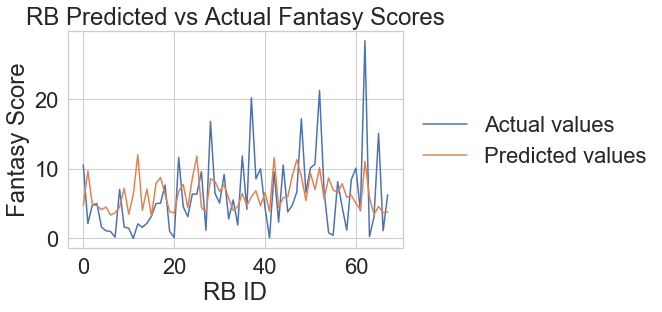

,RB,WR,QB,TE
RandomForest_train,2.746774,0.0,3.194120,0.0
RandomForest_cv,3.817722,0.0,3.818151,0.0
RandomForest_test,5.103411,0.0,7.100701,0.0


In [49]:
y_pred_rb = gs_rb.best_estimator_.predict(x_test)
show_results(gs_rb.best_estimator_, "RandomForest", "RB", y_pred_rb, df_rmse, x_train, x_test, y_train, y_test)
df_rmse

#### WR

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


{'n_estimators': 400, 'min_samples_split': 23, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': False}


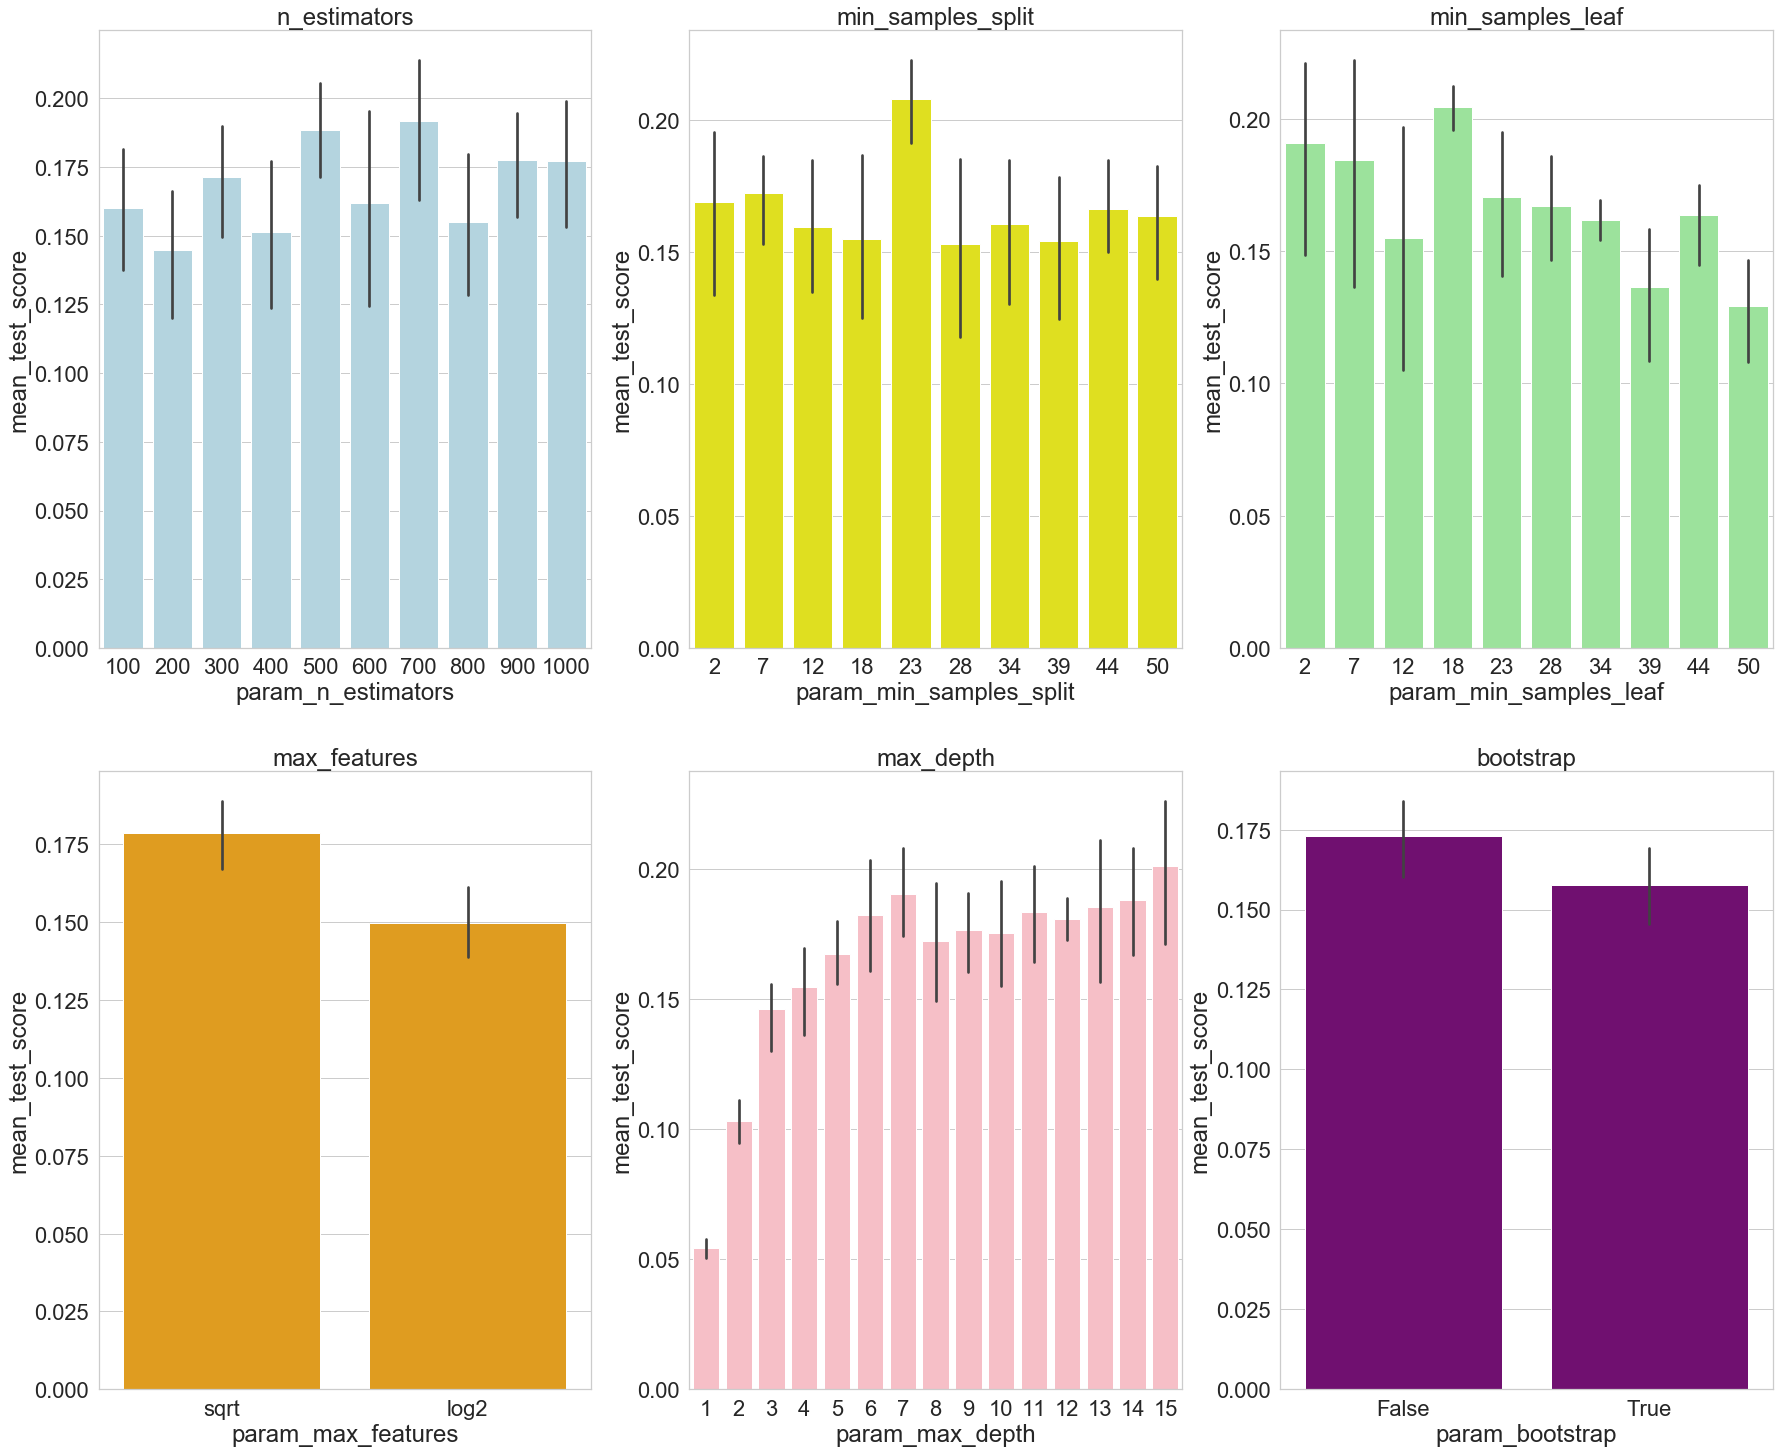

In [51]:
position = "WR"
x_train, x_test, y_train, y_test = position_test_train_split(position)
rs_wr = rf_rscv(x_train, y_train)
plot_rscv(rs_wr)

In [52]:
n_estimators = [300, 400, 500, 700]
max_features = ['sqrt']
max_depth = [15]
min_samples_split = [21, 22, 23, 24, 25]
min_samples_leaf = [2, 3, 4, 5, 17, 18, 19]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs_wr = GridSearchCV(RandomForestRegressor(), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs_wr.fit(x_train, y_train)
gs_wr.best_params_
# {'bootstrap': False,
# 'max_depth': 15,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 3,
# 'min_samples_split': 25,
# 'n_estimators': 500}

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.0min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 22,
 'n_estimators': 500}

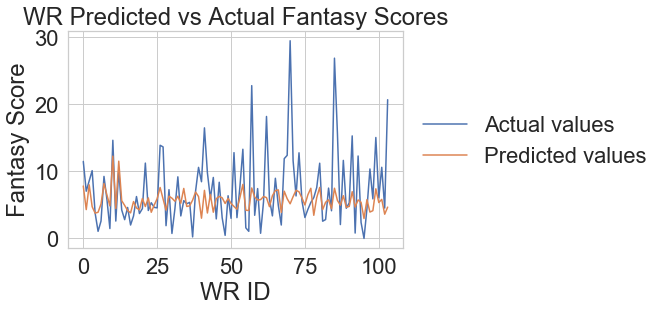

,RB,WR,QB,TE
RandomForest_train,2.746774,2.203611,3.194120,0.0
RandomForest_cv,3.817722,3.826483,3.818151,0.0
RandomForest_test,5.103411,5.329713,7.100701,0.0


In [53]:
y_pred_wr = gs_wr.best_estimator_.predict(x_test)
show_results(gs_wr.best_estimator_, "RandomForest", "WR", y_pred_wr, df_rmse, x_train, x_test, y_train, y_test)
df_rmse

#### TE

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 700, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': False}


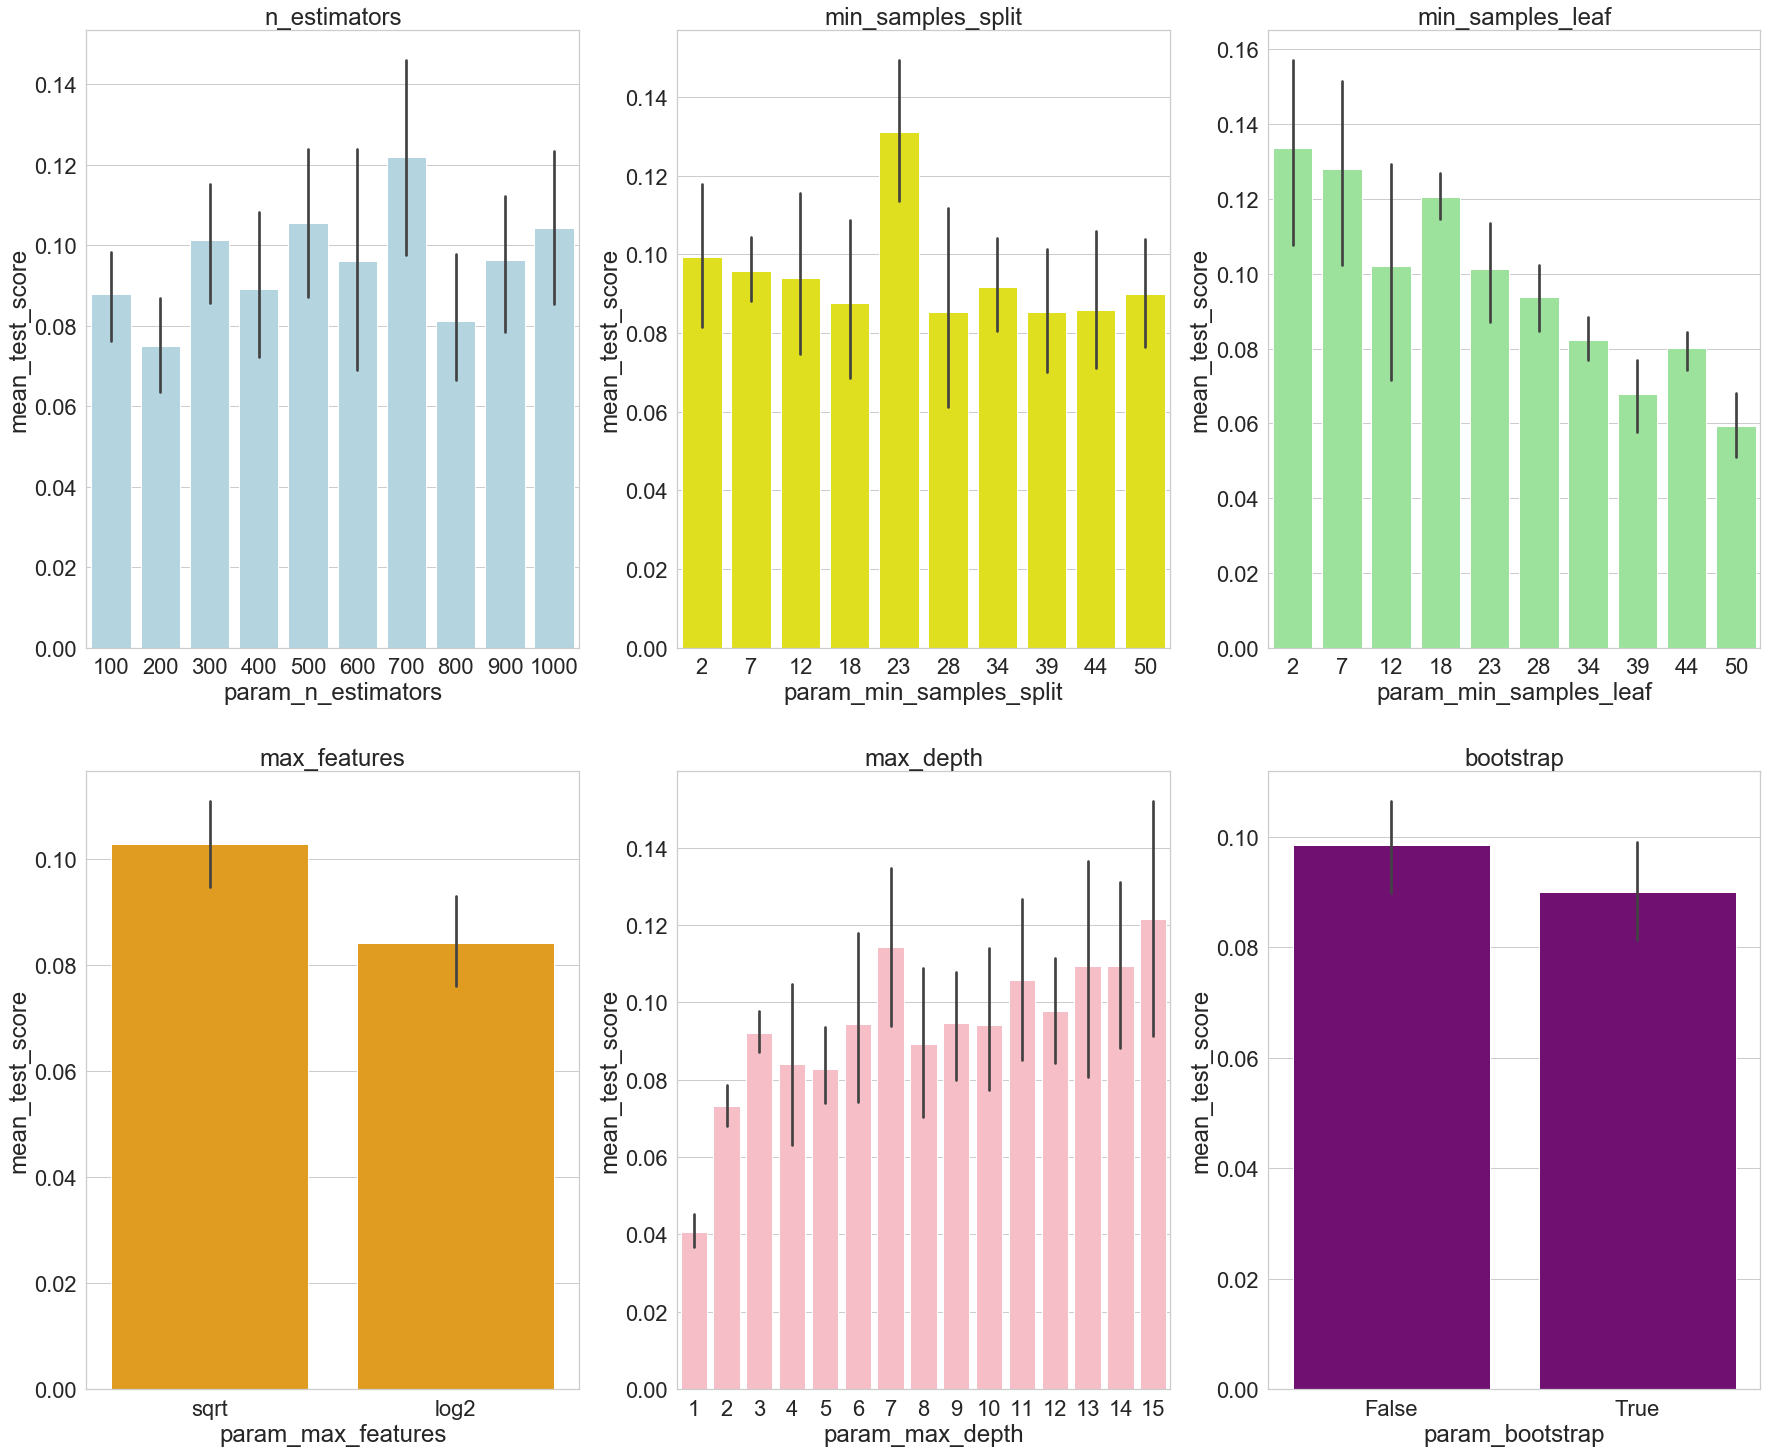

In [54]:
position = "TE"
x_train, x_test, y_train, y_test = position_test_train_split(position)
rs_te = rf_rscv(x_train, y_train)
plot_rscv(rs_te)

In [55]:
n_estimators = [500, 700, 1000]
max_features = ['sqrt']
max_depth = [7, 13, 14, 15]
min_samples_split = [21, 22, 23, 24, 25]
min_samples_leaf = [2, 3, 4, 5]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs_te = GridSearchCV(RandomForestRegressor(), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs_te.fit(x_train, y_train)
gs_te.best_params_
# {'bootstrap': False,
# 'max_depth': 15,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 3,
# 'min_samples_split': 25,
# 'n_estimators': 500}

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.9min finished
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': False,
 'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 23,
 'n_estimators': 500}

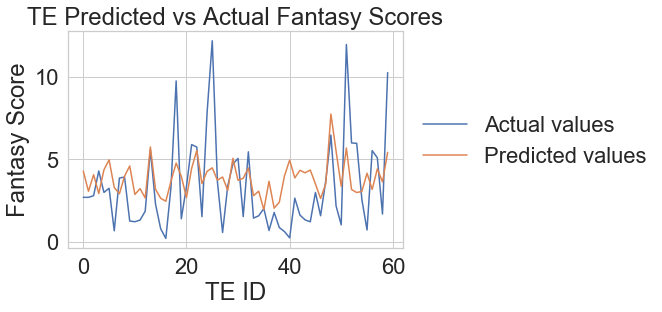

,RB,WR,QB,TE
RandomForest_train,2.746774,2.203611,3.194120,1.839662
RandomForest_cv,3.817722,3.826483,3.818151,3.822928
RandomForest_test,5.103411,5.329713,7.100701,2.495848


In [56]:
y_pred_te = gs_te.best_estimator_.predict(x_test)
show_results(gs_te.best_estimator_, "RandomForest", "TE", y_pred_te, df_rmse, x_train, x_test, y_train, y_test)
df_rmse

### Ridge Regression

Learning for Position RB ...


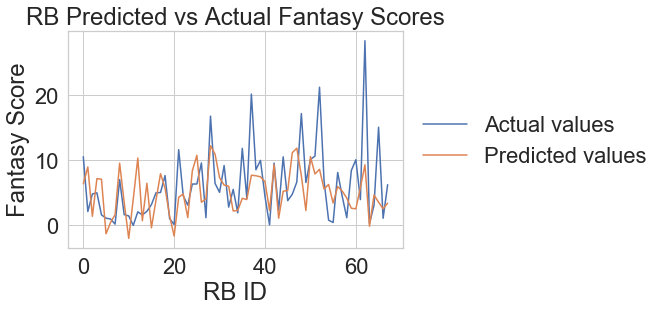

Learning for Position WR ...


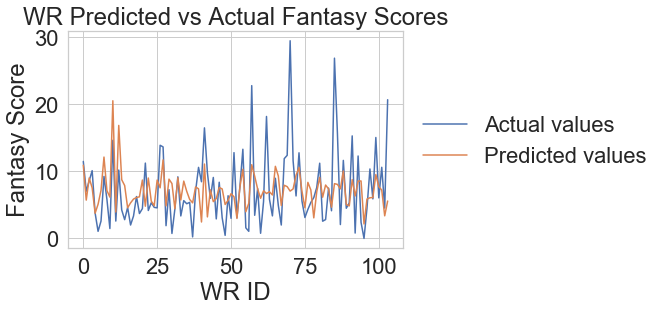

Learning for Position QB ...


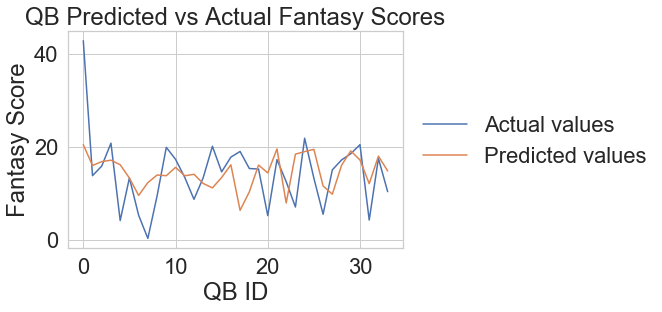

Learning for Position TE ...


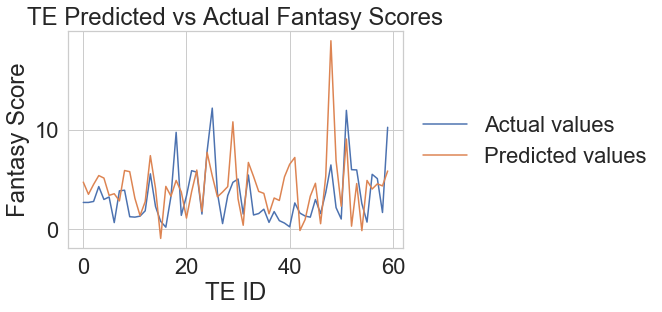

,RB,WR,QB,TE
Ridge_train,3.659220,3.092412,4.257558,2.355850
Ridge_cv,3.765933,3.765933,3.765933,3.765933
Ridge_test,5.066801,5.049151,6.942433,3.219003


In [65]:
rmse_names = ['Ridge' + '_' + y for y in types]
df_rmse = pd.DataFrame([[0.0] * len(positions) for j in range(len(rmse_names))], 
    index = rmse_names, columns = positions)

for i in range(len(positions)):
    position = positions[i]
    print ('Learning for Position %s ...' % position)
    features = players.select_dtypes(include=[np.number]).columns.tolist()
    features.remove('player_fant_pt_test')

    train = players[players.nfl_year.isin([2011, 2012, 2013, 2014, 2015, 2016])]
    test = players[players.nfl_year == 2017]
    df_pos_train = train.loc[train['player_pos'] == position,]
    df_pos_test = test.loc[test['player_pos'] == position,]
    grid_search = RidgeCV().fit(df_pos_train[features], df_pos_train['player_fant_pt_test'])
    
    y_test = df_pos_test['player_fant_pt_test']
    y_pred = grid_search.predict(df_pos_test[features])
    
    fix,ax = plt.subplots()
    plt.title('%s Predicted vs Actual Fantasy Scores'%position)
    ax.plot(list(y_test), label = "Actual values")
    ax.plot(list(y_pred), label = "Predicted values")
    plt.xlabel('%s ID'%position)
    plt.ylabel('Fantasy Score')
    plt.legend(loc='best', bbox_to_anchor=[1,0.7])
    plt.show()

    train_rmse = np.sqrt(np.mean( (df_pos_train['player_fant_pt_test'] - \
                grid_search.predict(df_pos_train[features]))**2.0 ))
    test_rmse = np.sqrt(np.mean( (df_pos_test['player_fant_pt_test'] - \
                grid_search.predict(df_pos_test[features]))**2.0 ))
        # Deprecating "mean_squared_error". Use "neg_mean_squared_error" instead.
    cv_rmse = np.sqrt(np.abs( cross_val_score(grid_search, train[features], train['player_fant_pt_test'],\
        cv = 5, scoring = 'neg_mean_squared_error').mean() ))

        # Given the variable name in a string, get the variable value and import into dataframe
    for val in types:
        df_rmse.loc["Ridge" + "_" + val, position] = eval(val + '_rmse')
df_rmse

### PCA

Learning for Position RB ...


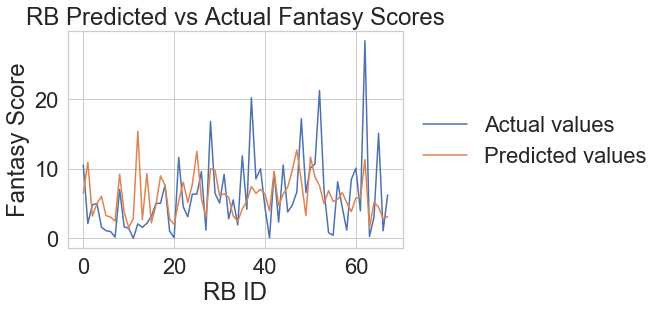

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


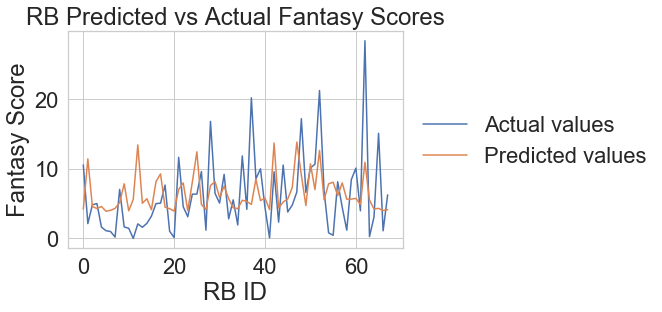

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Learning for Position WR ...


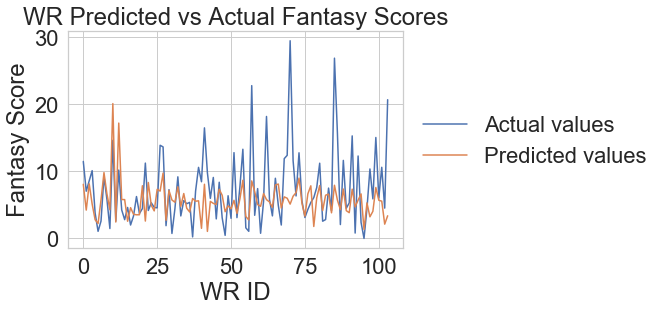

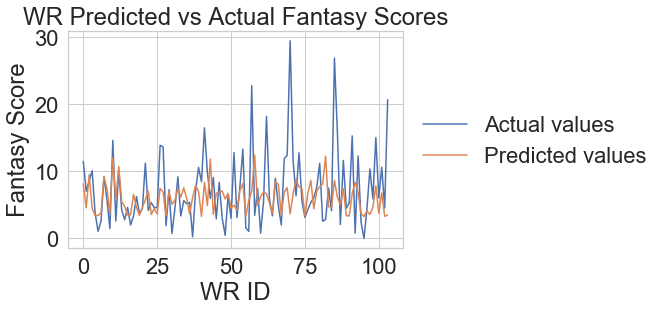

Learning for Position QB ...


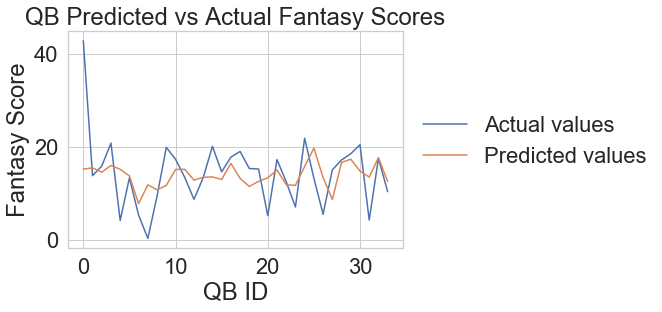

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


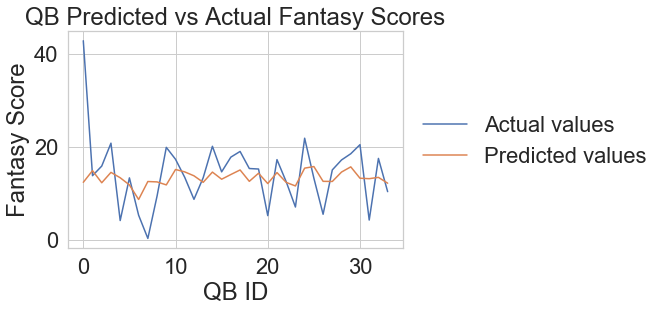

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Dep

Learning for Position TE ...


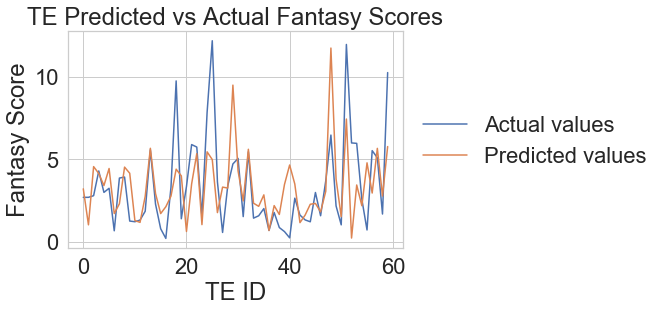

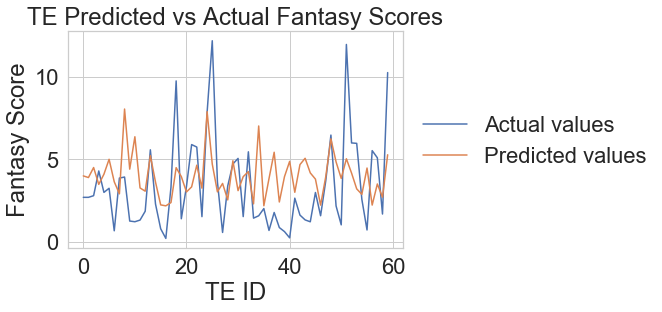

C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Cecilia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Dep

,RB,WR,QB,TE
Ridge_train,3.907989,3.193278,4.637270,2.558910
RandomForestRegressor_train,3.924321,3.137323,4.506884,2.500630
Ridge_cv,4.154453,3.453225,5.468200,2.911361
RandomForestRegressor_cv,4.074636,3.431720,5.067695,2.739922
Ridge_test,5.127714,5.389655,6.972794,2.372058
RandomForestRegressor_test,5.282787,5.529840,7.196127,2.770237


In [60]:
positions = ['RB', 'WR', 'QB', 'TE']
estimators = ["Ridge", "RandomForestRegressor" ]
types = ['train', 'cv', 'test']

rmse_names = [x + '_' + y for y in types for x in estimators]
df_rmse2 = pd.DataFrame([[0.0] * len(positions) for j in range(len(rmse_names))], 
    index = rmse_names, columns = positions)

ss = StandardScaler()

for position in positions:
    print ('Learning for Position %s ...' % position)
    features = players.select_dtypes(include=[np.number]).columns.tolist()
    features.remove('player_fant_pt_test')

    train = players[players.nfl_year.isin([2011, 2012, 2013, 2014, 2015, 2016])]
    test = players[players.nfl_year == 2017]
    df_pos_train = train.loc[train['player_pos'] == position,]
    df_pos_test = test.loc[test['player_pos'] == position,]
    
    x_train_scaled = ss.fit_transform(df_pos_train[features])
    x_test_scaled = ss.transform(df_pos_test[features])
    y_train = np.array(df_pos_train['player_fant_pt_test'])
    y_test = np.array(df_pos_test['player_fant_pt_test'])
    
    pca = PCA(n_components=30)
    pca.fit(x_train_scaled)
    x_train_scaled_pca = pca.transform(x_train_scaled)
    x_test_scaled_pca = pca.transform(x_test_scaled)

    for i in range(len(estimators)):
        est = estimators[i]

        if(est == "RandomForestRegressor"):
            n_estimators = [30, 50, 70, 100]
            param_grid = {'n_estimators': n_estimators}
            grid_search = GridSearchCV(RandomForestRegressor(max_depth=3), param_grid, cv=5)
            grid_search.fit(x_train_scaled_pca, y_train)

        elif(est == "Ridge"):
            grid_search = RidgeCV().fit(x_train_scaled_pca, y_train)

        else:
            print(est)
            print("Cannot find the algorithm")
            exit()
        
        y_pred = grid_search.predict(x_test_scaled_pca)
        
        fix,ax = plt.subplots()
        plt.title('%s Predicted vs Actual Fantasy Scores'%position)
        ax.plot(list(y_test), label = "Actual values")
        ax.plot(list(y_pred), label = "Predicted values")
        plt.xlabel('%s ID'%position)
        plt.ylabel('Fantasy Score')
        plt.legend(loc='best', bbox_to_anchor=[1,0.7])
        plt.show()
        
        train_rmse = np.sqrt(np.mean( (y_train - grid_search.predict(x_train_scaled_pca))**2.0 ))
        test_rmse = np.sqrt(np.mean( (y_test - y_pred)**2.0 ))
        cv_rmse = np.sqrt(np.abs( cross_val_score(grid_search, x_train_scaled, y_train,\
            cv = 5, scoring = 'neg_mean_squared_error').mean() ))

        for val in types:
            df_rmse2.loc[estimators[i] + "_" + val, position] = eval(val + '_rmse')
df_rmse2